# Machine Learning Algorithms on Predicting London Housing Prices

____

###### All the data would be download from London Datastore (https://data.london.gov.uk/dataset/house-price-per-square-metre-in-england-and-wales).
#### IMPORTANT: when using the docker, please adjust the maximum RAM size in settings (greater than 6GB), otherwise, it will crash when reading data. The initial data covers the entire England and Wales, which are too large and requires additional memory resources.
>Time consuming processes(using 100Mbps network and a 10 core Laptop CPU 'Apple M1'):

>>The Data Download and processing:      1 min 30 sec\
(skipped)Drop VIF:                    10 min \
(skipped)Random forest hyperparameters tuning:        3 min \
Random forest model:          2 min\
Small deep learning model:   40 sec\
Large deep learning model:    2 min
#### NOTE: All the initial output have kept as markdown for those skipped part

____

# Introduction

>Real estate is an important part of the national economy. It is crucial for the government
to comprehend factors such as the affordability and fairness of the housing market to help
them advance their policies. Consequently, predicting the value of properties is not only
advantageous to investors, but can also play a major role in the supervision of public welfare.

>The price of a house may depend on a number of diverse factors, inclusive of the location
and characteristics of the house, plus the demand and supply of real estate in the real estate
market. For example, investors often give more consideration to the long-term appreciation
rate of the property, rather than to the comfort of the property itself. As the availability of
open information increases and the source of that information becomes more apparent, the
complexity of building machine learning models for house price predictions is steadily
decreasing, and they are being developed at a rapid pace. Prior studies of the housing market
utilising machine learning processes can be split into two categories: trend predictions of
house price indexes (Lim et al., 2016; Gupta, Kabundi and Miller, 2011) and house price
valuations (Park and Bae, 2015; Phan, 2018).

>In housing price index forecasting, researchers aim to use past growth rates or house price
indexes to discover the best way to forecast the movement of the housing market. These are
typically calculated based on the national or regional standard house prices. In literature
reviews, academic research on this model type (in time dimensions) accounts for most
machine-learning housing studies. This type of model will frequently have a comparatively
high self-interpretation rate (e.g. R-square >97%, Lim et al., 2016, p. 519). On the other
hand, the house price valuation models like Park and Bae created for Fairfax County's
housing market (2015, pp. 2929-2933), still have a lot of scope for improvement.

>>It is worth noting that a model suitable for predicting house prices in a specific area may
not be appropriate for different regions. This could be because the way data is stored and
accessed across the regions varies, or the variables that scholars utilise to study the model are
more or less different. It could also be because there are major regional diversities in the real
estate market itself (Eichholtz, Veld, and Schweitzer, 2000, p. 215), so it is extremely
complex to locate the master variances and algorithms that can be applied to the whole
housing market. In this report, a subset of the data from Chi et al. (2020) is used to construct
a regression model to calculate house prices in London. Chi et al. created the dataset through
complex address-based matching between Land Registry's Price Paid Data and
information of property size in Ministry for Housing, Communities and Local Government.

### Setup

>package required:\
tensorflow 2.8.0\
pydot 1.4.2\
rfpimp latest\
geopy 2.2.0\
shapely 1.8.0


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import contextily as cx
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import urllib
import zipfile
from matplotlib import cm
from geopandas import GeoDataFrame
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from statsmodels.graphics.gofplots import qqplot
from IPython.core.interactiveshell import InteractiveShell
import rfpimp
import warnings
warnings.filterwarnings("ignore")

# Reseach question and data loading

### Can we build a machine learning model that predicts sale value for unseen data points?
>Are we able to use these variables to predict the unseen data points, for instance, the housing price that is not listed in the dataset?

>>And here is a table shows the descriptions of variables in the original data. 



![](https://github.com/aixiajiao/GISdata/raw/main/tabel1.jpg)

In [2]:
%%time
if not os.path.exists('dataset'):
    os.makedirs('dataset')

url = 'https://data.london.gov.uk/download/house-price-per-square-metre-in-england-and-wales/29ed9a44-3125-4bb2-91e5-87bbf190fe23/hpm_la.zip'

extract_dir = "dataset"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

CPU times: user 12.1 s, sys: 6 s, total: 18.1 s
Wall time: 1min 4s


In [3]:
%%time
#load all house price
import glob
path = "dataset"
data=[pd.read_csv(csv_file) \
                for path, subdir, _ in os.walk(path) \
                 for csv_file in glob.glob(os.path.join(path, "*.csv"))]
df = pd.concat(data, axis=0, ignore_index=True)

CPU times: user 20.6 s, sys: 4.7 s, total: 25.3 s
Wall time: 27.8 s


We only use the data from year 2020

In [4]:
df1=df.loc[(df.year == 2020)]

Then we download the London Borough shapefile from London Datastore, then we could use borough code to subset our dataset.

In [5]:
#download borough shapefile to limit the study area to London
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
extract_dir = "dataset"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [6]:
ldshp = gpd.read_file("dataset/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
ldborough=ldshp[['NAME','GSS_CODE','geometry']]
ldborough.head(2)

,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,"POLYGON ((535009.200 159504.700, 535005.500 15..."


In [7]:
df2=pd.merge(ldborough,df1,left_on='GSS_CODE',right_on='lad21cd',how='left').drop(['lad21cd'],axis=1)
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 60569 entries, 0 to 60568
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   NAME                         60569 non-null  object  
 1   GSS_CODE                     60569 non-null  object  
 2   geometry                     60569 non-null  geometry
 3   priceper                     60548 non-null  float64 
 4   year                         60569 non-null  int64   
 5   dateoftransfer               60569 non-null  object  
 6   propertytype                 60569 non-null  object  
 7   duration                     60569 non-null  object  
 8   price                        60569 non-null  float64 
 9   postcode                     60569 non-null  object  
 10  transactionid                60569 non-null  object  
 11  id                           60569 non-null  int64   
 12  tfarea                       60569 non-null  float64

# Data Cleanning

>Because real estate data is often entered manually by numerous agents, missing and erroneous information is unavoidable. For example, there are many missing or invalid data on the house's construction date, and about 10,000 transaction records do not include the properties’ number of rooms. Housing prices that are too high (more than twenty times than the mean value) or too low or even equal to zero have also been found. Apart from erroneous inputs, these real estate transactions may also include assets gifted between relatives and friends. These marginal values were removed so as not to affect model performance.
>>Log transform was used to normalise the unit price data making the price data nearer to a normal distribution. But when the 'distplot' function from the seaborn package was used, the log-transformed price was still looks somewhat skewed, so Tukey's method was performed to exclude all the mild outliers

In [8]:
#Drop columns that are irrelevant or unnecessary to our analysis
ld_refine = df2.drop(['year','transactionid','id','classt','price','GSS_CODE','geometry'], axis = 1)

In [9]:
df = ld_refine.drop_duplicates() #delete duplicate rows
df = df[df.CONSTRUCTION_AGE_BAND != 'NO DATA!']  #delete NA value for the construction year
df = df[df.CONSTRUCTION_AGE_BAND != 'INVALID!']
df.CONSTRUCTION_AGE_BAND = df.CONSTRUCTION_AGE_BAND.str.strip('England and Wales:')#delete unwanted characters
#Transfer columns to the right data type 
df['CONSTRUCTION_AGE_BAND'] = pd.Categorical(df.CONSTRUCTION_AGE_BAND)
df['propertytype'] = pd.Categorical(df.propertytype)
df['dateoftransfer'] = pd.to_datetime(df['dateoftransfer'])
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51152 entries, 1 to 60568
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   NAME                         51152 non-null  object        
 1   priceper                     51152 non-null  float64       
 2   dateoftransfer               51152 non-null  datetime64[ns]
 3   propertytype                 51152 non-null  category      
 4   duration                     51152 non-null  object        
 5   postcode                     51152 non-null  object        
 6   tfarea                       51152 non-null  float64       
 7   numberrooms                  51152 non-null  float64       
 8   CURRENT_ENERGY_EFFICIENCY    51152 non-null  int64         
 9   POTENTIAL_ENERGY_EFFICIENCY  51152 non-null  int64         
 10  CONSTRUCTION_AGE_BAND        51152 non-null  category      
dtypes: category(2), datetime64[ns](1), float6

We could use distplot to check weather the price per unit meter is skewed.

<AxesSubplot:xlabel='priceper', ylabel='Density'>

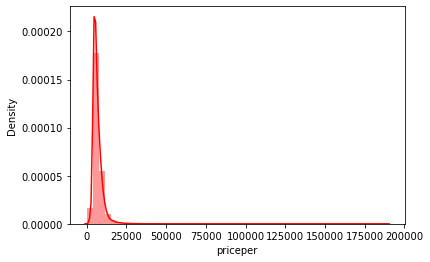

In [10]:
 sns.distplot(df['priceper'],kde=True,color='red')

<AxesSubplot:xlabel='pp_log', ylabel='Density'>

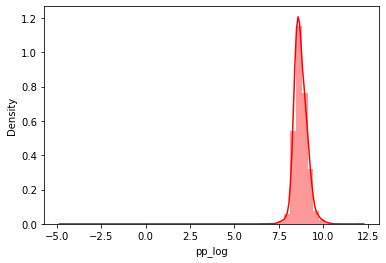

In [11]:
#Transform 'priceper' to log, here we don't have to add 1 to the original column as the min value is not zero.
log_pp = np.log(df['priceper'])
#df['pp_+1'] = df['priceper']+1
#log_pp = np.log(df['pp_+1'])
df['pp_log'] = log_pp
#Plot
sns.distplot(df['pp_log'],kde=True,color='red')

the logged price are still a bit skewd, we need to further delete some outliers

In [12]:
#Detecting outliers  Tukeys method
def outlierfence(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence (mild outliers)
    lower_inner_fence = q1-inner_fence
    upper_inner_fence = q3+inner_fence
    
    #outer fence (extreme outliers)
    lower_outer_fence = q1-outer_fence
    upper_outer_fence = q3+outer_fence
    
    return print (f"""The lower inner fence is {lower_inner_fence}
The upper inner fence is {upper_inner_fence}
The lower outer fence is {lower_outer_fence}
The upper outer fence is {upper_outer_fence}""")

In [13]:
outlierfence(df, 'pp_log')

The lower inner fence is 7.7691154110383325
The upper inner fence is 9.663171673907282
The lower outer fence is 7.058844312462476
The upper outer fence is 10.37344277248314


<AxesSubplot:xlabel='pp_log', ylabel='Density'>

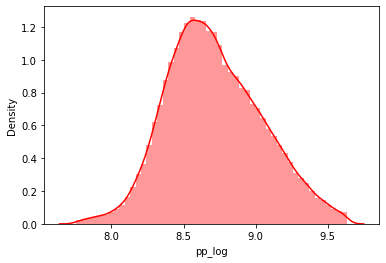

In [14]:
#df1 exclude mild outliers using inner fence
df1 = df[(df.pp_log > 7.752002278332048) & (df.pp_log < 9.636521495405594)]
sns.distplot(df1['pp_log'],kde=True,color='red')

### Data Exploration

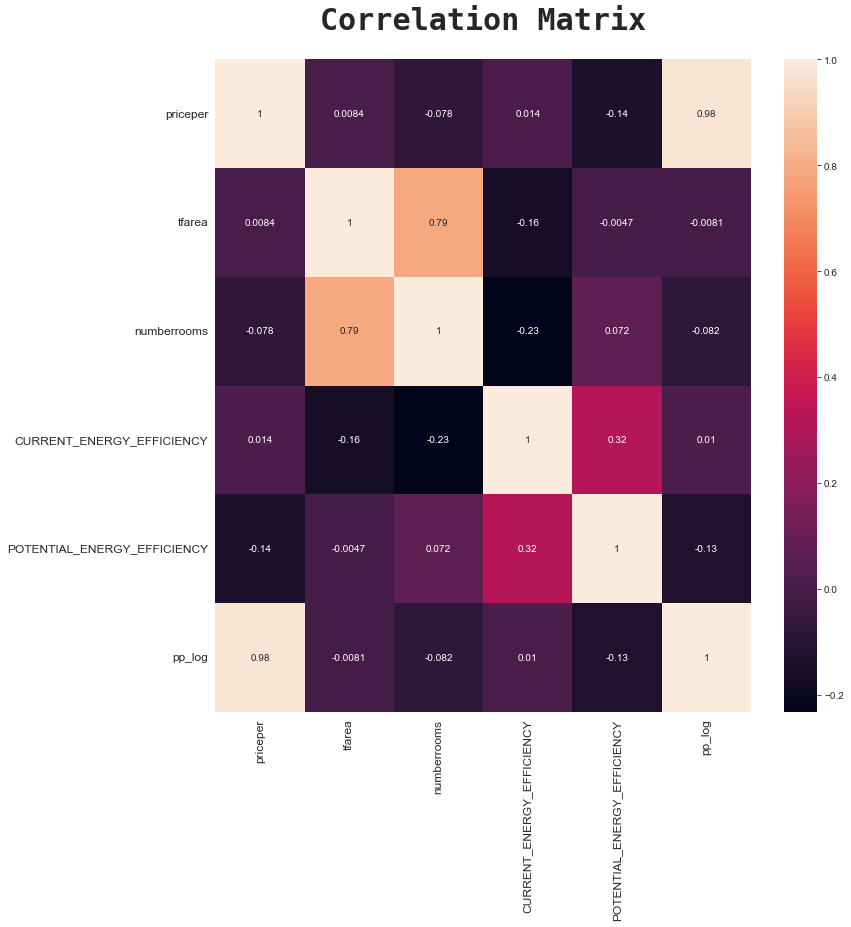

In [15]:
# let's make a correlation matrix
sns.set_style("whitegrid") # set the seaborn style
plt.figure(figsize=(12, 12)) # figure the size
sns.heatmap(df1.corr(), annot=True) # create a heatmap
plt.title("Correlation Matrix", weight="bold", fontsize=30, fontname="monospace", pad=30) # title
plt.xticks(weight="light", fontsize=12) # x-ticks
plt.yticks(weight="light", fontsize=12); # y-ticks

In [16]:
(df1.corr()["pp_log"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,pp_log,priceper,CURRENT_ENERGY_EFFICIENCY,tfarea,numberrooms,POTENTIAL_ENERGY_EFFICIENCY
pp_log,1.0,0.977579,0.010404,-0.008072,-0.081867,-0.130126


In [17]:
Borough_avg_price=df1.groupby(['NAME']).agg(
    {'priceper':['mean','median']}).sort_values(('priceper','median'))
print(Borough_avg_price.head(2))
print(Borough_avg_price.tail(2))

                         priceper             
                             mean       median
NAME                                          
Barking and Dagenham  4250.763654  4214.285714
Havering              4641.304687  4555.555556
                            priceper              
                                mean        median
NAME                                              
City of London          11807.801673  11861.090731
Kensington and Chelsea  11513.471714  12041.890014


In [18]:
Borough_avg_price_gdf = pd.merge(ldborough,Borough_avg_price,on='NAME')

In [19]:
list(Borough_avg_price_gdf)

['NAME', 'GSS_CODE', 'geometry', ('priceper', 'mean'), ('priceper', 'median')]

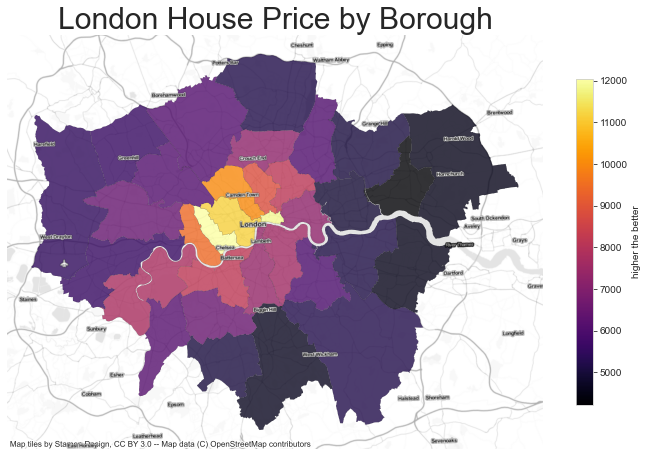

In [20]:
ax=Borough_avg_price_gdf.plot(figsize=(12, 12), cmap='inferno',alpha=0.8, linewidth=0.1,edgecolor='k',
            column=('priceper', 'median'),legend=True,
           legend_kwds={'label': "higher the better",'orientation': "vertical",'shrink': 0.5})
ax.set_title("London House Price by Borough",fontsize= 30)
ax.set_axis_off()
cx.add_basemap(ax, crs=Borough_avg_price_gdf.crs, source=cx.providers.Stamen.TonerLite, alpha=0.7)
cx.add_basemap(ax, crs=Borough_avg_price_gdf.crs, source=cx.providers.Stamen.TonerLabels)

Location frequently plays an essential part in housing prices, and houses far from the city centre are typically comparatively cheap (Luca, 2019, p. 84). In this report, we use the postcode from the dataset to obtain the coordinates for each property. However, this step is very time-consuming. For the convenience of the execution, this step has been skipped.

My initial plan was:\
Add IMD score as an additional feature to the dataset based on Lower Layer Super Output Area (LSOA) where the property located (use spatial join).
LSOA is the smallest census unit for the British government to gather data in England and Wales. The data based on this is normally the most comprehensive in the government's public information database. The IMD score takes into account multiple sets of data to develop an overall rank for deprivation. This not only reveals residents' income, but also includes, for example, local education level, crime rate, living environment, accessibility of medical resources and other details. Even though IMD only provided the relative gaps between regions, these variables were enough to help improve the model. 

we just drop the postcode column out of the dataframe ***only for this time***

In [21]:
df1.drop(['postcode'],axis=1,inplace=True)

In [22]:
#use 0 and 1 to indicate weather the property is lease hold or not
du = {'L':1, 'F':0}
df1['duration'] = df1.duration.replace(du)

In [23]:
df1.head(2)

,NAME,priceper,dateoftransfer,propertytype,duration,tfarea,numberrooms,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,CONSTRUCTION_AGE_BAND,pp_log
1,Kingston upon Thames,8243.090351,2020-11-19,F,1,61.87,3.0,84,88,2003-2006,9.017131
2,Kingston upon Thames,6956.521739,2020-10-28,F,1,46.00,2.0,74,74,1991-1995,8.847435


In [24]:
#make categorical data into dummy variables
age_dummies = pd.get_dummies(df1["CONSTRUCTION_AGE_BAND"])
df1 = pd.concat([df1,age_dummies],axis=1).drop(["CONSTRUCTION_AGE_BAND"],axis=1)
pt_dummies = pd.get_dummies(df1["propertytype"],prefix='type')
df1 = pd.concat([df1,pt_dummies],axis=1).drop(["propertytype"],axis=1)
area_dummies = pd.get_dummies(df1["NAME"])
df1 = pd.concat([df1,area_dummies],axis=1).drop(["NAME"],axis=1)

In [25]:
df1.head(2)

,priceper,dateoftransfer,duration,tfarea,numberrooms,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,pp_log,1900-1929,1930-1949,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
1,8243.090351,2020-11-19,1,61.87,3.0,84,88,9.017131,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6956.521739,2020-10-28,1,46.00,2.0,74,74,8.847435,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#also change dates to dummy variables, we only keep month
df1['transfer_month'] = df1['dateoftransfer'].dt.month
month_dummies = pd.get_dummies(df1["transfer_month"],prefix='month')
df1 = pd.concat([df1,month_dummies],axis=1).drop(["transfer_month",'dateoftransfer'],axis=1)

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49872 entries, 1 to 60568
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   priceper                     49872 non-null  float64
 1   duration                     49872 non-null  int64  
 2   tfarea                       49872 non-null  float64
 3   numberrooms                  49872 non-null  float64
 4   CURRENT_ENERGY_EFFICIENCY    49872 non-null  int64  
 5   POTENTIAL_ENERGY_EFFICIENCY  49872 non-null  int64  
 6   pp_log                       49872 non-null  float64
 7   1900-1929                    49872 non-null  uint8  
 8   1930-1949                    49872 non-null  uint8  
 9   1950-1966                    49872 non-null  uint8  
 10  1967-1975                    49872 non-null  uint8  
 11  1976-1982                    49872 non-null  uint8  
 12  1983-1990                    49872 non-null  uint8  
 13  1991-1995       


**Location** frequently plays an essential part in housing prices, and houses far from the city centre are typically comparatively cheap (Luca, 2019, p. 84).Since we have the postcode of each transaction, we can actually use tools such as geopy to calculate the location of each transaction, and use these coordinates to calculate the distance from the house to the city center, subway station, etc. But since doing so takes more time, we can use borough names to achieve a similar effect.
 >‘NAME’ was turned into 32 dummy variables, corresponding to 32 boroughs in London. For example, if a particular property was located in Camden, the value of its Camden variable will be equal to 1, and the other 31 values will be equal to 0. Comparable operations can also be applied at the time of the transaction (considering that 2020 was a more severe year for the COVID epidemic in London, where a blockade was encountered, and the timing of the transaction may considerably affect the closing transaction price), housing type, the construction time of the house (because the construction time in this form is a band of years, not an exact time) and tenure of dwelling, that all these variables were converted into dummy variables. Thus, those categorical data could be converted to a numeric format to build the regressor.

# Methodology

>This report will mainly focus on supervised learning models. 

>The first main model to be used is called Random Forest (RF) Regressors. RF is based on the concept of Essemble Learning - using multiple simple predictors in order to make better predictions. The hypothesis is that multiple learners will yield better results than single learners.A RF model is based on multiple Decision Trees (DTs). DTs are a supervised learning method used for classification and regression, each has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.

>Trees can be "learned" by splitting the source set into subsets based on attribute value tests. This process is repeated on each derived subset in a recursive fashion called recursive partitioning. The recursion is done when the subsets at the node all have the same value of the target variable, or when the split no longer adds value to the prediction.

>A Random Forest model predicted values or categorise observations based on fitting a multitude of DTS, each on samples drawn with replacement (i.e., bootstrap sample) from the training set. The outcomes from multiple trees across multiple observations are often 1. the one that is most often predicted (majority voting) or 2. the mean or average prediction across multiple trees.

**But first we will do a Linear Regression model as a baseline model for comparison.**

### Prepare Data for Regression

In [28]:
#Split X and y
X = df1.drop(columns=['priceper','pp_log'])
y = df1['pp_log']

In [29]:
#Normalize the data
from scipy.stats import skew
numeric_data=X.select_dtypes(include=[np.number])
skewed = X[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed_positive = skewed[(skewed > 0.75)]
skewed_positive = skewed_positive.index
X[skewed_positive] = np.log1p(X[skewed_positive])
skewed_negative = skewed[(skewed < -0.75)]
skewed_negative = skewed_negative.index
X[skewed_negative] = np.log1p(X[skewed_negative])
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

In the privious step, we use the skew tool from scipy package to detect all the skewed variables, then applied log transformation.

In [30]:
#Split test and train data
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=1)#Use scaled_X
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1024)
X_train.head(2)

,duration,tfarea,numberrooms,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,1900-1929,1930-1949,1950-1966,1967-1975,1976-1982,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
25803,-0.784836,-1.805565,-1.679222,0.779197,0.051509,-0.584204,-0.624318,-0.341803,-0.260971,-0.178143,...,-0.315505,-0.2062,-0.205671,-0.257668,-0.297177,-0.309281,-0.329488,-0.360786,-0.345922,-0.327465
36215,-0.784836,-1.695836,-0.775407,-0.641878,-3.451737,-0.584204,-0.624318,-0.341803,-0.260971,-0.178143,...,-0.315505,-0.2062,-0.205671,-0.257668,3.364997,-0.309281,-0.329488,-0.360786,-0.345922,-0.327465


In [31]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34910, 65)
(7481, 65)
(7481, 65)


In [32]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

The Variance Inflation Factor (VIF) measures the severity of multicollinearity in regression analysis. For multicollinearity, the regression coefficients are still consistent, but are no longer reliable because the standard errors are inflated. This means that the predictive power of the model is not reduced, but the coefficients may not be statistically significant with a Type II error. Thus, if the coefficients of a variable are not individually significant—cannot be rejected separately in the t-test—but can be jointly explained by the rejection in the F-test and a high coefficient of determination (R2) for the variance of the dependent variable, there may be multiple collinearity. It is one of the methods to detect multicollinearity. We need to remove those columns to correct the multicollinearity by applying the above function.

> As dropping VIF would took too long, we will drop it directly without actually run the code.

> The initial output:

In [33]:
X_train_VIF =X_train.drop(['City of London','2007 onwar','month_3',
                        'type_D','Bromley','type_F','1930-1949','duration'],axis=1)
#also drop the VIF from the test and validate dataset
X_test_VIF=X_test.drop(['City of London','2007 onwar','month_3',
                        'type_D','Bromley','type_F','1930-1949','duration'],axis=1)
X_val_VIF=X_val.drop(['City of London','2007 onwar','month_3',
                        'type_D','Bromley','type_F','1930-1949','duration'],axis=1)

In [34]:
#Check the shape
print(X_train_VIF.shape)
print(X_val_VIF.shape)
print(X_test_VIF.shape)

(34910, 57)
(7481, 57)
(7481, 57)


## Regression Models

### Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
lr=LinearRegression()
lr.fit(X_train_VIF,y_train)
y_pred=lr.predict(X_test_VIF)
print ('MSE: ',mean_squared_error(y_test,y_pred))
print ('MAE: ',mean_absolute_error(y_test,y_pred))
print ('Adj_R2:', 1-((1-r2_score(y_test,y_pred))*(len(y_train)-1))/(len(y_train)-X_train_VIF.shape[1]-1)) 

MSE:  0.053542835409719415
MAE:  0.1758171603432781
Adj_R2: 0.5137114790294531


In [36]:
print(f'Train Dataset Score: {lr.score(X_train_VIF, y_train).round(3)}')
print(f'Validate Dataset Score: {lr.score(X_val_VIF, y_val).round(3)}')
print(f'Test Dataset Score: {lr.score(X_test_VIF, y_test).round(3)}')

Train Dataset Score: 0.522
Validate Dataset Score: 0.514
Test Dataset Score: 0.515


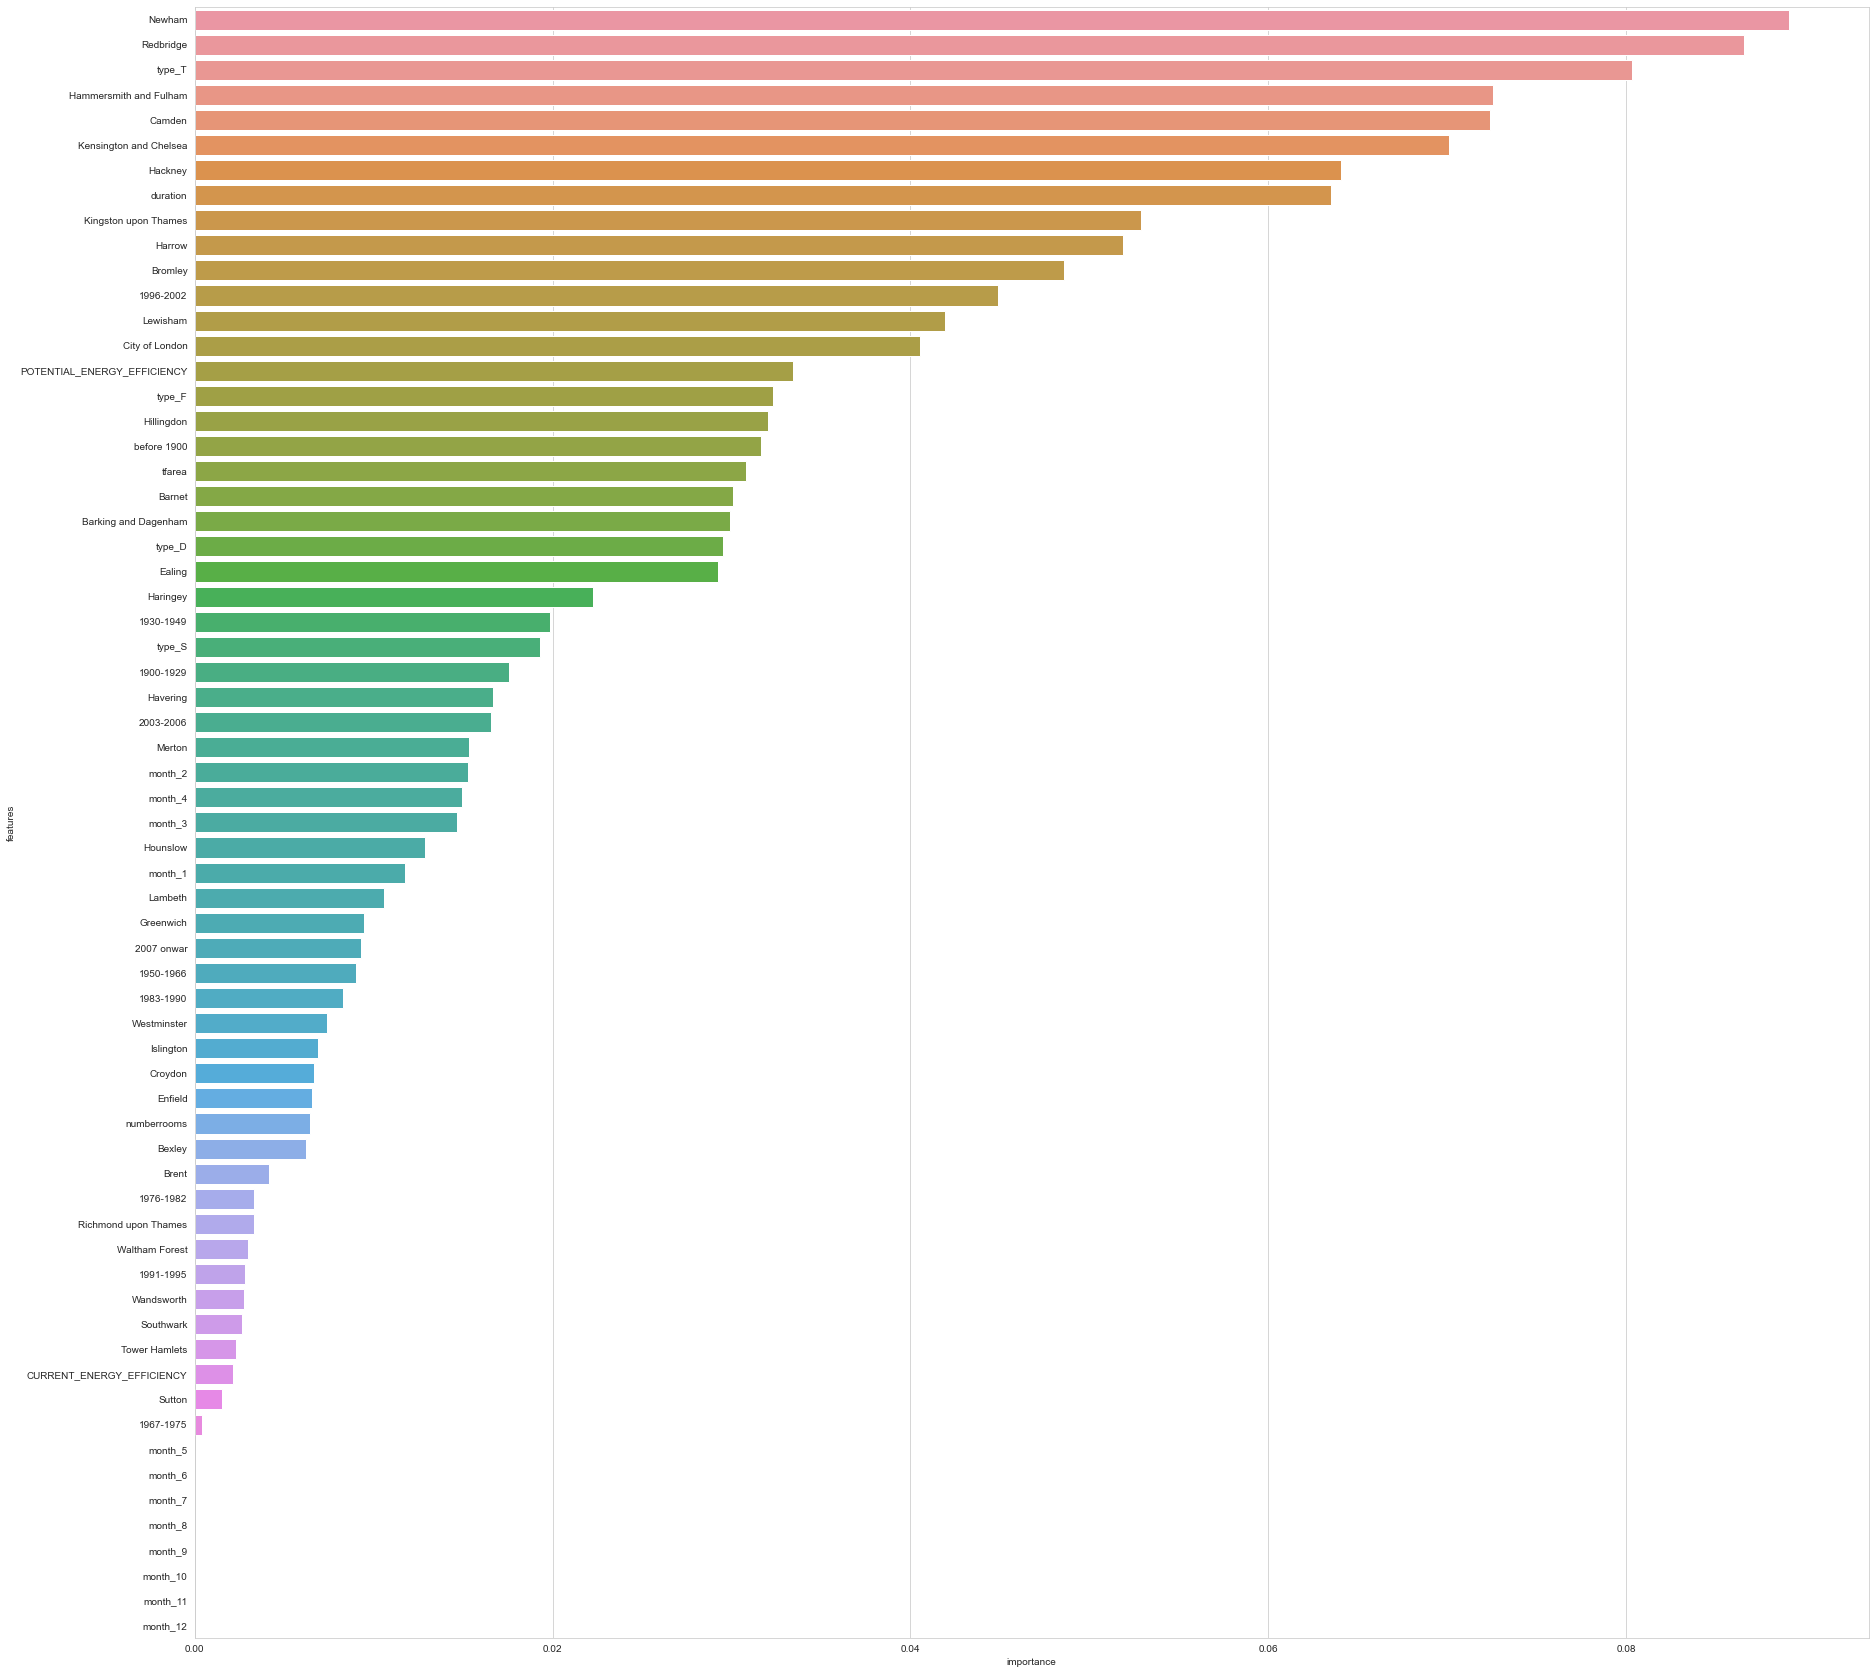

In [37]:
coef = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coef.columns=['features','importance']
coef['importance']=np.abs(coef['importance'])
coef=coef.sort_values(by='importance',ascending=False)
plt.figure(figsize=(30,30))
sns.barplot(x='importance',y='features',data=coef,)
plt.show()

>What is extremely applicable to life experience is that it is easy to guess the approximate valuation when you know the geographical location of the property and its type. In this case, the Borough names have played an important rule in our Linear Regression model.
>>The house’s age is also one of the crucial points that normal home buyers would think about, as newly built houses typically have more advanced supporting facilities. 

### Random Forest

In [38]:
#No need to delete VIF in RF model
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34910, 65)
(7481, 65)
(7481, 65)


In [39]:
%%time
from sklearn.ensemble import RandomForestRegressor
randomState_rf = 1024
rf = RandomForestRegressor(n_estimators=100, random_state=randomState_rf)
rf.fit(X_train, y_train) 
print("R2 on the training data:")
print(rf.score(X=X_train, y=y_train))
print("R2 on the validating data:")
print(rf.score(X=X_val, y=y_val))
print("R2 on the testing data:")
print(rf.score(X=X_test, y=y_test))

R2 on the training data:
0.939366766045811
R2 on the validating data:
0.5731209668062115
R2 on the testing data:
0.5604106340831123
CPU times: user 18 s, sys: 69.4 ms, total: 18 s
Wall time: 18.1 s


### Use GridSearchCV to Improve RF Model

>This is the process of performing hyperparameter tuning to determine the best value for a given model. The performance of the model depends heavily on the values of the hyperparameters. GridSearchCV tries all combinations of the values passed in the dictionary and evaluates the model for each combination using a cross-validation method. So after using this function, we get the accuracy/loss for each combination of hyperparameters and we can choose the one with the best performance.

In [40]:
# merge training and validation data, as required by GridSearchCV
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])                       

# the index list of training and validation data in the merged dataset
# in X_train_val, the first n rows are from X_train and the remaining rows are from X_val. Here n=X_train.shape[0]
ind_train = list(range(X_train.shape[0]))
ind_val = list(range(X_train.shape[0], X_train_val.shape[0]))

In [41]:
%%time
#rf_final = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'], random_state=randomState_rf)
rf_final = RandomForestRegressor(n_estimators=200, random_state=10000)
rf_final.fit(X_train, y_train)
print('The score on the training data:')
print(rf_final.score(X_train, y_train))
print('The score on the development data:')
print(rf_final.score(X_val, y_val))
print('The score on the testing data:')
print(rf_final.score(X_test, y_test))

The score on the training data:
0.9408371838616174
The score on the development data:
0.5755755822186615
The score on the testing data:
0.5624521636314961
CPU times: user 35.6 s, sys: 162 ms, total: 35.8 s
Wall time: 35.9 s


                Importance
Feature                   
tfarea            0.537747
1900-1929         0.188669
before 1900       0.159019
duration          0.142587
Westminster       0.128079
...                    ...
1983-1990         0.003570
1976-1982         0.002631
2007 onwar        0.002523
1991-1995         0.001950
City of London    0.000621

[65 rows x 1 columns]


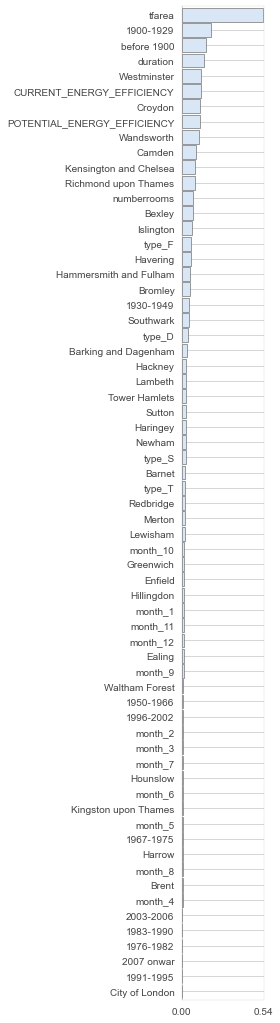

In [42]:
imp = rfpimp.importances(rf_final, X_train, y_train) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

The coefficient of random forest model shows the total area of housing has contributed a lot in predicting housing prices. The pattern is very different from the linear model.
Most unexpectedly, it was found that the real estate transaction time could actually manipulate the closing transaction amount, and buyers don’t appear to seriously consider the energy efficiency of houses. This paper believes that due to the pandemic of COVID-19, house prices will fluctuate sharply in 2020. Liu and Su's research reveals that the supply and demand of the housing market have changed after the epidemic (2021, p. 4). Housing demand in dense communities has decreased, so has the demand to live close to work. Rather, housing demand has gradually moved from the city to the suburbs. These trends are apt to be reflected in our data as the time dimension changes.

## Tensorflow 

>Deep learning is based on artificial neural network (ANN), which usually consists of input layer, hidden layer and output layer, and is generally used to process large data sets. ANN is a computing system inspired by biological neural networks to perform different tasks involving large amounts of data, these networks are trained to produce the desired output, and different models are used to predict future outcomes of the data. These nodes are connected to each other, making it work like a human brain. Different correlations and hidden patterns in the raw data are used to cluster and classify the data. 

>We will use tensorflow to build a simple multi-layer feedforward network. In a multilayer feedforward network, there are multiple hidden layers in addition to the input and output layers. The nodes in this layer are called hidden neurons or hidden units. The role of the hidden layer is to intervene between the output and the external input. The input layer node provides the input signal to the node of the second layer, the hidden layer, the output of the hidden layer acts as the input of the next layer, which will continue to the rest of the network. Through these 'layers', the model can continuously improve its recognition ability to achieve an effect similar to human brain learning.

In [43]:
#Use Mergered Dataset for tensorflow analysis
print(X_train_val.shape)
print(y_train_val.shape)
print(X_test.shape)

(42391, 65)
(42391,)
(7481, 65)


In [44]:
#Transfer Dataset to tensorshape format
X_trainT, X_testT = tf.constant(X_train_val, dtype=tf.float32), tf.constant(X_test, dtype=tf.float32)

y_trainT, y_testT = tf.constant(y_train_val, dtype=tf.float32), tf.constant(y_test, dtype=tf.float32)


Metal device set to: Apple M1 Pro


2022-04-25 16:20:57.400790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-25 16:20:57.400937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
# Checking the shape and dimension of rows and columns (features)
X_trainT.shape, X_testT.shape, X_trainT.ndim, X_testT.ndim

(TensorShape([42391, 65]), TensorShape([7481, 65]), 2, 2)

In [46]:
# Checking the shape and dimension of rows and columns (label)
y_trainT.shape, y_testT.shape, y_trainT.ndim, y_testT.ndim

(TensorShape([42391]), TensorShape([7481]), 1, 1)

In [47]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [49]:
%%time

# Set random seed
set_seed()

# Create the model
small_TFmodel = tf.keras.Sequential([
    layers.Dense(100, activation="relu", input_shape=[65], name="input_1"),
    layers.Dense(10, activation="relu", name="input_2"),
    layers.Dense(1, name="output_layer")
], name="small_model")

# Compile the model
small_TFmodel.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

# Fit the model
small_TFmodel_history = small_TFmodel.fit(
    X_trainT, y_trainT, 
    validation_data=(X_testT, y_testT),
    epochs=5)

Epoch 1/5


2022-04-25 16:20:57.551454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-25 16:20:57.712778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1320/1325 [============================>.] - ETA: 0s - loss: 0.5560 - mae: 0.5560

2022-04-25 16:21:04.064268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1325/1325 [==============================] - 7s 5ms/step - loss: 0.5549 - mae: 0.5549 - val_loss: 0.2354 - val_mae: 0.2354
Epoch 2/5
1325/1325 [==============================] - 7s 5ms/step - loss: 0.2207 - mae: 0.2207 - val_loss: 0.2550 - val_mae: 0.2550
Epoch 3/5
1325/1325 [==============================] - 7s 5ms/step - loss: 0.2044 - mae: 0.2044 - val_loss: 0.2022 - val_mae: 0.2022
Epoch 4/5
1325/1325 [==============================] - 7s 5ms/step - loss: 0.1975 - mae: 0.1975 - val_loss: 0.1947 - val_mae: 0.1947
Epoch 5/5
1325/1325 [==============================] - 7s 5ms/step - loss: 0.1923 - mae: 0.1923 - val_loss: 0.1997 - val_mae: 0.1997
CPU times: user 25.1 s, sys: 16.2 s, total: 41.3 s
Wall time: 33.9 s


In [50]:
small_TFmodel.evaluate(X_testT, y_testT) 

234/234 [==============================] - 1s 3ms/step - loss: 0.1997 - mae: 0.1997


[0.19966386258602142, 0.19966386258602142]

In [51]:
small_TFmodel.summary()

Model: "small_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (Dense)             (None, 100)               6600      
                                                                 
 input_2 (Dense)             (None, 10)                1010      
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 7,621
Trainable params: 7,621
Non-trainable params: 0
_________________________________________________________________


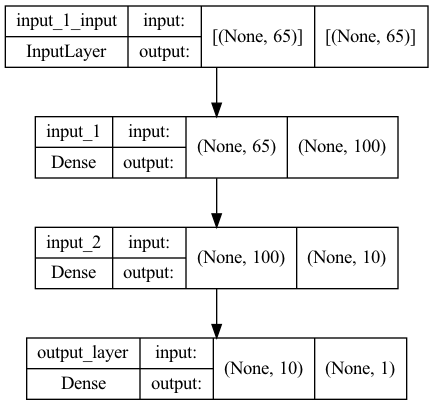

In [52]:
tf.keras.utils.plot_model(small_TFmodel, show_shapes=True)

In [53]:
def plot_loss_curves(history):
    # Loss and Val_loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Mae and Val Mae
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    
    # set the epochs
    epochs = range(len(history.history["loss"]))
    
    # Plot loss
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training_loss", marker="o", markerfacecolor="k")
    plt.plot(epochs, val_loss, label="Val_loss", marker="o", markerfacecolor="b")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label="Training_mae", marker="o", markerfacecolor="k")
    plt.plot(epochs, val_mae, label="Val_mae", marker="o", markerfacecolor="b")
    plt.title("MAE")
    plt.xlabel("Epochs")
    plt.legend();

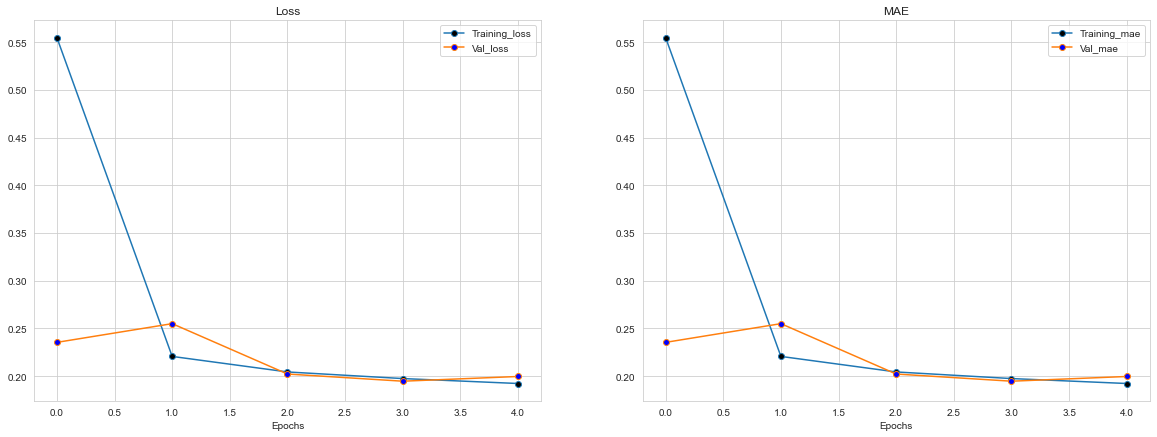

In [54]:
plot_loss_curves(small_TFmodel_history)

### Add some complexity to the TF model

In [55]:
%%time
set_seed()
TFmodel = tf.keras.Sequential([
    layers.Dense(200, activation="relu", input_shape=[65], name="input_1"),
    layers.Dense(200, activation="relu", name="input_2"),
    layers.Dense(10, activation="relu", name="input_3"),
    layers.Dense(1, activation="relu", name="output_layer")
], name="TFmodel")
TFmodel.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["mae"])
TFmodel_history = TFmodel.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=15)

Epoch 1/15
   9/1091 [..............................] - ETA: 7s - loss: 2.9373 - mae: 2.9373  

2022-04-25 16:21:32.908082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1091/1091 [==============================] - ETA: 0s - loss: 0.5058 - mae: 0.5058

2022-04-25 16:21:38.859043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1091/1091 [==============================] - 7s 6ms/step - loss: 0.5058 - mae: 0.5058 - val_loss: 0.2465 - val_mae: 0.2465
Epoch 2/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.2544 - mae: 0.2544 - val_loss: 0.2207 - val_mae: 0.2207
Epoch 3/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.1889 - mae: 0.1889 - val_loss: 0.1666 - val_mae: 0.1666
Epoch 4/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.1722 - mae: 0.1722 - val_loss: 0.1641 - val_mae: 0.1641
Epoch 5/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.1706 - mae: 0.1706 - val_loss: 0.1802 - val_mae: 0.1802
Epoch 6/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.1714 - mae: 0.1714 - val_loss: 0.1691 - val_mae: 0.1691
Epoch 7/15
1091/1091 [==============================] - 6s 6ms/step - loss: 0.1737 - mae: 0.1737 - val_loss: 0.1728 - val_mae: 0.1728
Epoch 8/15
1091/1091 [==============================] - 7s 6ms/step - los

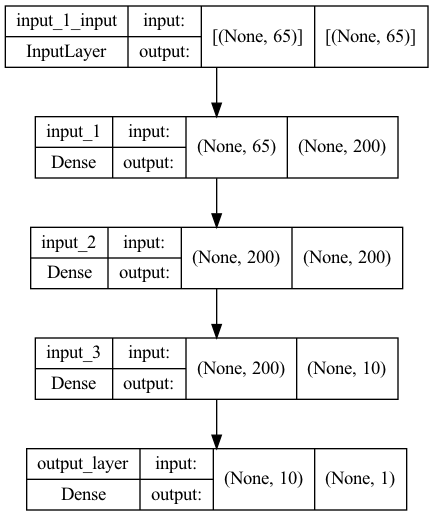

In [56]:
tf.keras.utils.plot_model(TFmodel, show_shapes=True) 

In [57]:
TFmodel.evaluate(X_test, y_test)

234/234 [==============================] - 1s 3ms/step - loss: 0.1986 - mae: 0.1986


[0.19855646789073944, 0.19855646789073944]

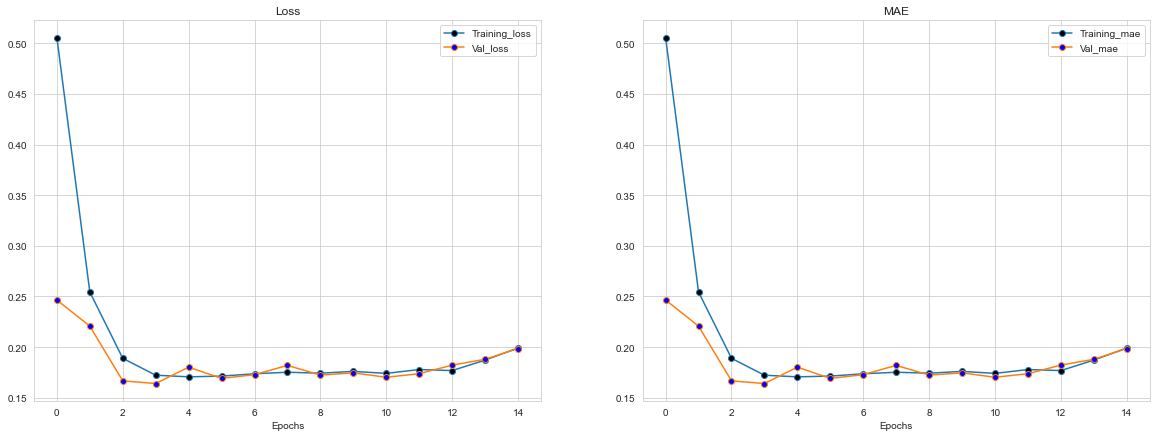

In [58]:
plot_loss_curves(TFmodel_history)

We could see there has been serval times that both the validation loss and train_loss is increasing in the large deep learning models. That could be over-fitting. As the model continues to get better at fitting the training data while getting worse at fitting the validation data. It happens when the model explains the training data too well, rather than picking up patterns that can help generalize over unseen data. 

# Results and Discussion

In [59]:
y_pred_lr=lr.predict(X_test_VIF)
print ('LinearModel_MSE: ',mean_squared_error(y_test,y_pred_lr))
print ('LinearModel_MAE: ',mean_absolute_error(y_test,y_pred_lr))
y_pred_rf=rf_final.predict(X_test)
print ('RandomForest_MSE: ',mean_squared_error(y_test,y_pred_rf))
print ('RandomForestl_MAE: ',mean_absolute_error(y_test,y_pred_rf))

y_pred_tfs=small_TFmodel.predict(X_test)
print ('TenserFlowsmall_MSE: ',mean_squared_error(y_test,y_pred_tfs))
print ('TenserFlowsmall_MAE: ',mean_absolute_error(y_test,y_pred_tfs))

y_pred_tfl=TFmodel.predict(X_test)
print ('TenserFlow_MSE: ',mean_squared_error(y_test,y_pred_tfl))
print ('TenserFlow_MAE: ',mean_absolute_error(y_test,y_pred_tfl))



LinearModel_MSE:  0.053542835409719415
LinearModel_MAE:  0.1758171603432781
RandomForest_MSE:  0.04825503016371662
RandomForestl_MAE:  0.16392805798093474


2022-04-25 16:23:08.777233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


TenserFlowsmall_MSE:  0.06706725508814841
TenserFlowsmall_MAE:  0.19966391314060458


2022-04-25 16:23:09.156894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


TenserFlow_MSE:  0.06731114507891989
TenserFlow_MAE:  0.1985564435356775


## Use Residuals to Evaluate the Models

In [60]:
validate = scaled_X
validate_VIF = scaled_X.drop(['City of London','2007 onwar','month_9',
                        'type_D','Bromley','type_F','1930-1949','duration'],axis=1)

In [61]:
validateT=tf.constant(validate, dtype=tf.float32)

In [62]:
results = pd.DataFrame()
residual= pd.DataFrame()
results['priceper'] = df1['priceper']

In [63]:
from math import e
results['tfSpred']= e**(small_TFmodel.predict(validateT))
residual['tfSresidual'] = results['tfSpred']-results['priceper']
results['tfLpred']= e**(TFmodel.predict(validateT))
residual['tfLresidual'] = results['tfLpred']-results['priceper']
results['lrpred']= e**(lr.predict(validate_VIF))#VIF for linear
residual['lrresidual'] = results['lrpred']-results['priceper']
results['rfpred']= e**(rf_final.predict(validate))
residual['rfresidual'] = results['rfpred']-results['priceper']

2022-04-25 16:23:09.585933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-25 16:23:11.844010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [64]:
residual.describe()

,tfSresidual,tfLresidual,lrresidual,rfresidual
count,49872.000000,49872.000000,49872.000000,49872.000000
mean,-148.621238,-354.356544,-173.215778,-103.757121
std,1806.177214,1690.167477,1547.969640,936.762485
min,-10154.330358,-10453.288835,-10145.088007,-11084.254681
25%,-978.672019,-1223.085715,-907.967908,-416.651210
50%,-63.800466,-269.442198,-17.942236,-12.525706
75%,813.824321,570.209416,747.070325,304.676731
max,98219.471532,12488.963235,9463.634718,9482.106195


<AxesSubplot:ylabel='Density'>

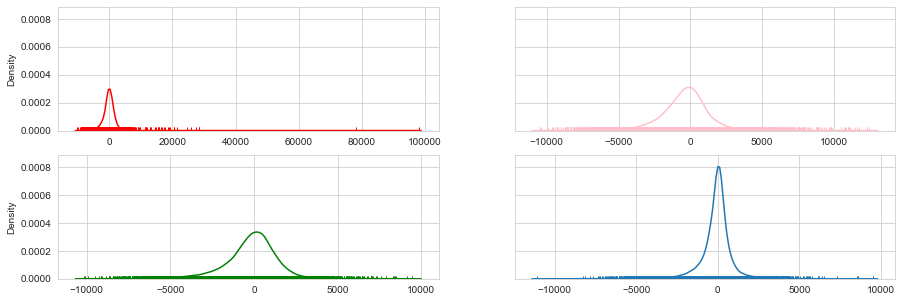

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey=True)
sns.distplot(residual[['tfSresidual']], hist=False, rug=True,ax=axes[0,0],color='red')
sns.distplot(residual[['tfLresidual']], hist=False, rug=True,ax=axes[0,1],color='pink')
sns.distplot(residual[['lrresidual']], hist=False, rug=True,ax=axes[1,0],color='green')
sns.distplot(residual[['rfresidual']], hist=False, rug=True,ax=axes[1,1])


The residual of the four model shows the random forest model has the overall best performance:
the blue graph has the highest density at 0 on x-axis means the overall predictions are more accurate that there is no particularly large difference between the forecast and the actual price. The Random Forest model also has the lowest mean square error as well as the lowest mean absolute error.

Suprisingly, the two ANN models have the worst performance, the simple tensorflow model has the worst accuracy and highest mean abosolute error, as the MSE is the average squared distance between the observed and predicted values, a high MSE also reflects on how the residual of the tensorflow model are all over the place.

However, we also discovered that using a deep learning model can quickly get a 'reliabel' result. The term 'quickly' is mainly manifested in that there is no need to compare too much between the ordinary models (like OLS,Decision tree, XGboost, etc.), but simply by increasing the number of hidden layers and computing epochs to achieve similar results. We didn't actually tweak the parameters of the small model much, let alone change our training data. And the problem of too high prediction price of small model is greatly improved after increasing the learning period. Deep learnning technic can save a lot of brain power.


### Use the info of my current house:

In [66]:
W = pd.DataFrame().reindex_like(X)#create an empty dataframe with same columns as our train dataframe
W = W.drop_duplicates()
W[np.isnan(W)] = 0

In [67]:
Lease_or_Freehold = 1 #1 for leaser hold, 0 for free hold
Total_Area = 60
Number_of_Rooms = 3
Current_energy_efficiency = 74
Potential_energy_efficiency = 81
Construction_year = 1940 #could be an estimate
W['type_F']=1    #change the type from F: flats, T: terraced, S: semi-detached, D: detached
W['Camden']=1   #change it to the correct borough
W['month_1']=1  #the month you wish to do transaction.

In [68]:
if Construction_year > 2007:
    W['2007 onwar']=1,
elif Construction_year <2007 and Construction_year >2002:
        W['2003-2006']=1,
elif Construction_year <2003 and Construction_year >1995:
            W['1996-2002']=1,
elif Construction_year <1996 and Construction_year >1990:
                W['1991-1995']=1,
elif Construction_year <1991 and Construction_year >1982:
                    W['1983-1990']=1,
elif Construction_year <1983 and Construction_year >1975:
                        W['1976-1982']=1,
elif Construction_year <1976 and Construction_year >1966:
                            W['1967-1975']=1,
elif Construction_year <1967 and Construction_year >1949:
                                W['1950-1966']=1,
elif Construction_year <1950 and Construction_year >1929:
                                    W['1930-1949']=1,
elif Construction_year <1930 and Construction_year >1899:
                                        W['1900-1929']=1,
else:
                                            W['before 1900']=1

In [69]:
W['duration']= Lease_or_Freehold 
W['tfarea']= Total_Area
W['numberrooms']=Number_of_Rooms
W['CURRENT_ENERGY_EFFICIENCY']= Current_energy_efficiency
W['POTENTIAL_ENERGY_EFFICIENCY']=Potential_energy_efficiency

In [70]:
scaled_W = pd.DataFrame(scaler.fit_transform(W),columns=W.columns)
WRF = W.tfarea.values * e**rf_final.predict(scaled_W) 
WTF = W.tfarea.values * e**TFmodel.predict(scaled_W) 
print(WRF)
print(WTF)

[305819.08510061]
[[282528.54492188]]


#### RQ: Can we build a machine learning model that predicts sale value for unseen data points?
#### Yes! 
>>A flat in the same building was sold at 310,000 in 2016, if we does not take appreciation rate over thses years into account, I think the results are very close to the real value.

>Which means we could use our model to predict the housing price for other properties that are not listed on the market.


# Conclusion

>An attempt was made to use both the random forest model and tensorflow deep learning model to predict the price of the apartment where the author presently resides. The outcome was very close to other units sold online in the same building.This paper considers that machine learning algorithms can enhance the predictability of housing prices and contribute considerably to an accurate evaluation of real estate prices. 

>A more highly refined model would help financial companies conduct improved real estate assessments and decrease loan risks. For example, we can find the specific location of each property according to the post code, and add more new variables to improve the accuracy. We can use the coordinates to calculate the great circle distance from the house to the city center, or the distance from the nearest subway station. It is also possible to use the spatial join method as a unit of LSOA to add data such as the median income of the community to help improve the prediction accuracy of the models. However, as mentioned in the introduction, the model constructed for the London area is not likely applicable to real estate valuations in dissimilar regions due to the huge geographical disparities in the real estate market. The 2020 data especially reveals the impact of the time dimension on real estate prices. Future models may need to consider additional variables to improve valuation precision.

# References:
>Chi, B., Dennett, A., Oléron-Evans, T., & Morphet, R. (2021). Shedding new light on
 residential property price variation in England: A multi-scale exploration. Environment and
 Planning B: Urban Analytics and City Science, 48(7), 1895-1911.
 
>Eichholtz, P., Schweitzer, M., & Op’t Veld, H. (2000). REIT performance: does managerial
 specialization pay. The performance of financial institutions. Cambridge University Press,
 Cambridge, 199-220.
 
>Park, B., & Bae, J. K. (2015). Using machine learning algorithms for housing price prediction: The case of Fairfax County, Virginia housing data. Expert systems with applications, 42(6), 2928-2934.

>Liu, S., & Su, Y. (2021). The impact of the Covid-19 pandemic on the demand for density:
Evidence from the US housing market. Economics letters, 207, 110010.

>Lim, W. T., Wang, L., Wang, Y., & Chang, Q. (2016, August). Housing price prediction
 using neural networks. In 2016 12th International conference on natural computation, fuzzy
 systems and knowledge discovery (ICNC-FSKD) (pp. 518-522). IEEE.
 
>d'Acci, L. (2019). Quality of urban area, distance from city centre, and housing value. Case
 study on real estate values in Turin. Cities, 91, 71-92.